# Predict CO2 Emissions in Rwanda

Hi again! In this project I am doing some forecasting. It is based on Kaggle competition - Predict CO2 Emissions in Rwanda. The ability to accurately monitor carbon emissions is a critical step in the fight against climate change. Precise carbon readings allow researchers and governments to understand the sources and patterns of carbon mass output. While Europe and North America have extensive systems in place to monitor carbon emissions on the ground, there are few available in Africa. The objective of this challenge is to create a machine learning models using open-source CO2 emissions data from Sentinel-5P satellite observations to predict future carbon emissions. These solutions may help enable governments, and other actors to estimate carbon emission levels across Africa, even in places where on-the-ground monitoring is not possible.

<img src="img/rwanda_forest.jpg" alt="Rwanda forest photo" title="Just Rwanda forest" />

# Import libraries

In [46]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor

# Data gathering

### Dataset description

The objective of this challenge is to create machine learning models that use open-source emissions data (from Sentinel-5P satellite observations) to predict carbon emissions.

Approximately 497 unique locations were selected from multiple areas in Rwanda, with a distribution around farm lands, cities and power plants. The data for this competition is split by time; the years 2019 - 2021 are included in the training data, and my task was to predict the CO2 emissions data for 2022 through November.

Seven main features were extracted weekly from Sentinel-5P from January 2019 to November 2022. Each feature (Sulphur Dioxide, Carbon Monoxide, etc) contain sub features such as column_number_density which is the vertical column density at ground level, calculated using the DOAS technique. I was given the values of these features in the test set and my goal was to predict CO2 emissions using time information as well as these features.

You can read more about dataset columns and their subfeatures below:
 - [Sulphur Dioxide](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S5P_NRTI_L3_SO2?hl=en)
 - [Carbon Monoxide](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S5P_NRTI_L3_CO?hl=en)
 - [Nitrogen Dioxide](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S5P_NRTI_L3_NO2?hl=en)
 - [Formaldehyde](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S5P_NRTI_L3_HCHO?hl=en)
 - [UV Aerosol Index](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S5P_NRTI_L3_AER_AI?hl=en)
 - [Ozone](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S5P_NRTI_L3_O3?hl=en)
 - [Cloud](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S5P_OFFL_L3_CLOUD?hl=en)


Load the data file and have an initial look into it

In [2]:
data = pd.read_csv('data/train.csv')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79023 entries, 0 to 79022
Data columns (total 76 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   ID_LAT_LON_YEAR_WEEK                                      79023 non-null  object 
 1   latitude                                                  79023 non-null  float64
 2   longitude                                                 79023 non-null  float64
 3   year                                                      79023 non-null  int64  
 4   week_no                                                   79023 non-null  int64  
 5   SulphurDioxide_SO2_column_number_density                  64414 non-null  float64
 6   SulphurDioxide_SO2_column_number_density_amf              64414 non-null  float64
 7   SulphurDioxide_SO2_slant_column_number_density            64414 non-null  float64
 8   SulphurDioxide_c

There is no region that would have all values measured. Let's see the first lines of the dataframe:

In [5]:
data.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-0.510_29.290_2019_00,-0.51,29.29,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,...,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994
1,ID_-0.510_29.290_2019_01,-0.51,29.29,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,...,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176
2,ID_-0.510_29.290_2019_02,-0.51,29.29,2019,2,0.000514,0.748199,0.000385,0.110018,72.795837,...,4216.986492,60068.894448,3516.282669,21.103410,0.251101,15.377883,30.401823,-142.519545,26.193296,4.231381
3,ID_-0.510_29.290_2019_03,-0.51,29.29,2019,3,NaN,NaN,NaN,NaN,NaN,...,5228.507736,51064.547339,4180.973322,15.386899,0.262043,-11.293399,24.380357,-132.665828,28.829155,4.305286
4,ID_-0.510_29.290_2019_04,-0.51,29.29,2019,4,-0.000079,0.676296,-0.000048,0.121164,4.121269,...,3980.598120,63751.125781,3355.710107,8.114694,0.235847,38.532263,37.392979,-141.509805,22.204612,4.347317


### Testing data
Get data to predict

In [39]:
test_data = pd.read_csv('data/test.csv')
test_data.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle
0,ID_-0.510_29.290_2022_00,-0.51,29.29,2022,0,NaN,NaN,NaN,NaN,NaN,...,36022.027344,8472.313477,41047.937500,7472.313477,7.935617,0.240773,-100.113792,33.697044,-133.047546,33.779583
1,ID_-0.510_29.290_2022_01,-0.51,29.29,2022,1,0.000456,0.691164,0.000316,0.000000,76.239196,...,48539.737242,6476.147323,54915.708579,5476.147161,11.448437,0.293119,-30.510319,42.402593,-138.632822,31.012380
2,ID_-0.510_29.290_2022_02,-0.51,29.29,2022,2,0.000161,0.605107,0.000106,0.079870,-42.055341,...,34133.080469,8984.795703,39006.093750,7984.795703,10.753179,0.267130,39.087361,45.936480,-144.784988,26.743361
3,ID_-0.510_29.290_2022_03,-0.51,29.29,2022,3,0.000350,0.696917,0.000243,0.201028,72.169566,...,50854.991076,6014.724059,57646.368368,5014.724115,11.764556,0.304679,-24.465127,42.140419,-135.027891,29.604774
4,ID_-0.510_29.290_2022_04,-0.51,29.29,2022,4,-0.000317,0.580527,-0.000184,0.204352,76.190865,...,46594.685145,6849.280477,52896.541873,5849.280394,13.065317,0.284221,-12.907850,30.122641,-135.500119,26.276807


And let's create a column to serve as index for DataFrames with results

In [63]:
results_id = test_data['ID_LAT_LON_YEAR_WEEK']

# Exploratory data analysis

### Basic statistic distributions and values

First, let's have a look at the distribution of emission values:

In [22]:
data['emission'].describe()

count    79023.000000
mean        81.940552
std        144.299648
min          0.000000
25%          9.797995
50%         45.593445
75%        109.549595
max       3167.768000
Name: emission, dtype: float64

Let's create a DataFrame with grouped mean value

In [3]:
data_mean_emission_district = data.groupby(['latitude', 'longitude'])\
                                  .mean(numeric_only=True)['emission']

Check the distribution

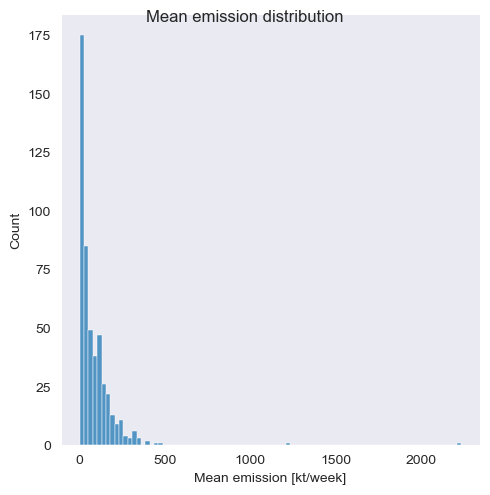

In [47]:
ax = sns.displot(data=data_mean_emission_district)
ax.fig.suptitle('Mean emission distribution')
ax.set_axis_labels('Mean emission [kt/week]')
plt.grid(False)

plt.show()

Find top 5 districts with highest emissions

In [4]:
data_mean_emission_district.sort_values(ascending=False)\
                           .head()

latitude  longitude
-2.378    29.222       2233.431628
-2.079    29.321       1221.886518
-1.346    31.254        475.289138
-0.956    30.744        455.398039
-1.342    31.358        409.606870
Name: emission, dtype: float64

### Highest emission regions charts during year
Let's have a look how does emission look thorough the year for 5 most emissive districts

In [5]:
data_mean_emission_week = data.groupby(['year', 'week_no'])\
                              .mean(numeric_only=True)['emission']\
                              .reset_index()
data_mean_emission_week.head()

,year,week_no,emission
0,2019,0,76.739149
1,2019,1,82.376350
2,2019,2,86.008823
3,2019,3,87.903964
4,2019,4,89.595095


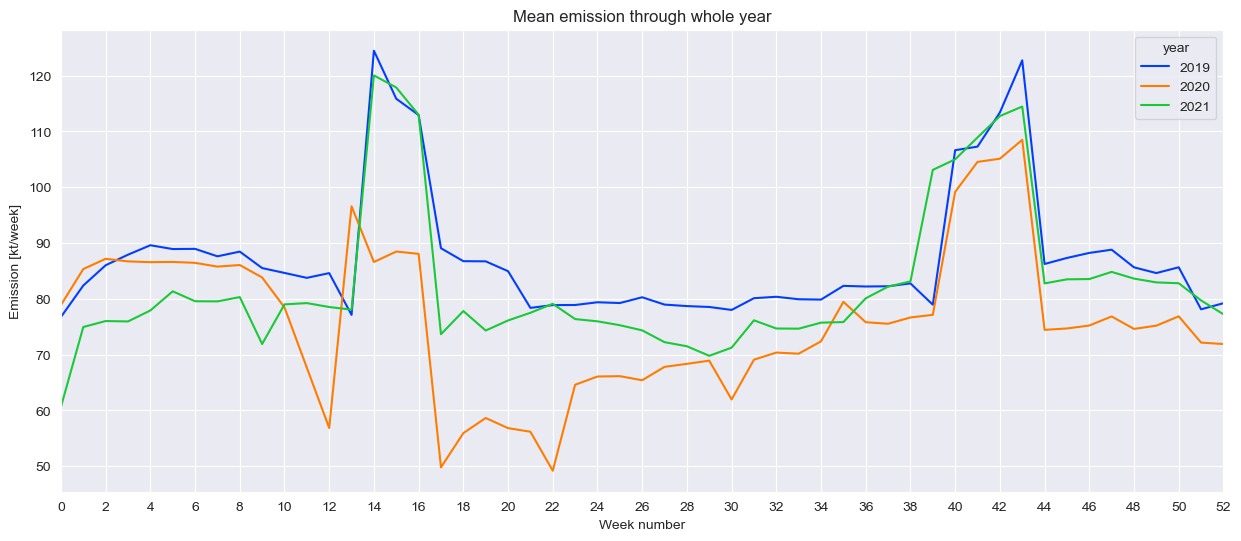

In [6]:
fig, ax = plt.subplots(figsize=(15,6))
ax = sns.lineplot(
    data=data_mean_emission_week,
    x='week_no',
    y='emission',
    hue='year',
    palette=sns.color_palette('bright', 3)
)

max_week = max(data_mean_emission_week['week_no'])
ax.set_xlabel('Week number')
ax.set_ylabel('Emission [kt/week]')
ax.set_title('Mean emission through whole year')
ax.set_xticks(range(0, max_week+1, 2))
ax.set_xlim(0, max_week)

plt.show()

We can see high annual peaks in mean emission in weeks 14-16 and 40-44. That means our data has seasonal characteristics and it will have to be taken into consideration during model training. What's more, there is vivid fall in emission in first months of 2020 which may indicate influence of COVID pandemic.

### Correlation analysis

In [85]:
print(data.corr(numeric_only=True)['emission']\
          .sort_values(ascending=False))

emission                                                    1.000000
longitude                                                   0.102746
UvAerosolLayerHeight_aerosol_height                         0.069008
Cloud_surface_albedo                                        0.046587
Formaldehyde_tropospheric_HCHO_column_number_density_amf    0.040263
                                                              ...   
Formaldehyde_tropospheric_HCHO_column_number_density       -0.033333
NitrogenDioxide_solar_azimuth_angle                        -0.033417
CarbonMonoxide_CO_column_number_density                    -0.041328
CarbonMonoxide_H2O_column_number_density                   -0.043217
UvAerosolLayerHeight_aerosol_pressure                      -0.068138
Name: emission, Length: 75, dtype: float64


We can see that all columns show correlation coefficient in range (-0.1, 0.1), which means there is no direct correlation between any of measured values and emission level.

# Feature engineering

### Target values for training
First let's extract them

In [35]:
train_emission = data['emission']

### One-hot encoding
I will create a DataFrame with weeks and years encoded one-hot to treat week number categorically.

In [31]:
weeks = data['week_no'].astype('category')
weeks_encoded = pd.get_dummies(weeks,
                               prefix='week',
                               drop_first=True)
weeks_encoded.head()

,week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,week_10,...,week_43,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51,week_52
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next I will extract other input data from our training set

In [34]:
data_for_encoded = data.drop(columns=['ID_LAT_LON_YEAR_WEEK', 'week_no', 'emission'])
data_for_encoded.head()

,latitude,longitude,year,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,...,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle
0,-0.51,29.29,2019,-0.000108,0.603019,-0.000065,0.255668,-98.593887,50.843559,-130.050797,...,53534.732422,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140
1,-0.51,29.29,2019,0.000021,0.728214,0.000014,0.130988,16.592861,39.137194,-140.874435,...,63790.296241,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779
2,-0.51,29.29,2019,0.000514,0.748199,0.000385,0.110018,72.795837,52.868816,-150.191757,...,55923.790554,4216.986492,60068.894448,3516.282669,21.103410,0.251101,15.377883,30.401823,-142.519545,26.193296
3,-0.51,29.29,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,44569.130636,5228.507736,51064.547339,4180.973322,15.386899,0.262043,-11.293399,24.380357,-132.665828,28.829155
4,-0.51,29.29,2019,-0.000079,0.676296,-0.000048,0.121164,4.121269,35.515587,-137.409159,...,59904.314844,3980.598120,63751.125781,3355.710107,8.114694,0.235847,38.532263,37.392979,-141.509805,22.204612


Merge the DFs above

In [37]:
input_for_encoded = pd.merge(weeks_encoded,
                             data_for_encoded,
                             left_index=True,
                             right_index=True)
input_for_encoded.head()

,week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,week_10,...,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle
0,0,0,0,0,0,0,0,0,0,0,...,53534.732422,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140
1,1,0,0,0,0,0,0,0,0,0,...,63790.296241,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779
2,0,1,0,0,0,0,0,0,0,0,...,55923.790554,4216.986492,60068.894448,3516.282669,21.103410,0.251101,15.377883,30.401823,-142.519545,26.193296
3,0,0,1,0,0,0,0,0,0,0,...,44569.130636,5228.507736,51064.547339,4180.973322,15.386899,0.262043,-11.293399,24.380357,-132.665828,28.829155
4,0,0,0,1,0,0,0,0,0,0,...,59904.314844,3980.598120,63751.125781,3355.710107,8.114694,0.235847,38.532263,37.392979,-141.509805,22.204612


### One-hot encoding - testing data
Do the same with testing dataset

In [51]:
weeks_test = data['week_no'].astype('category')
test_weeks_encoded = pd.get_dummies(weeks,
                                    prefix='week',
                                    drop_first=True)
test_weeks_encoded.head()

,week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,week_10,...,week_43,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51,week_52
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
test_data_for_encoded = test_data.drop(columns=['ID_LAT_LON_YEAR_WEEK', 'week_no'])
test_data_for_encoded.head()

,latitude,longitude,year,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,...,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle
0,-0.51,29.29,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,36022.027344,8472.313477,41047.937500,7472.313477,7.935617,0.240773,-100.113792,33.697044,-133.047546,33.779583
1,-0.51,29.29,2022,0.000456,0.691164,0.000316,0.000000,76.239196,15.600607,-140.529848,...,48539.737242,6476.147323,54915.708579,5476.147161,11.448437,0.293119,-30.510319,42.402593,-138.632822,31.012380
2,-0.51,29.29,2022,0.000161,0.605107,0.000106,0.079870,-42.055341,39.889060,-136.908976,...,34133.080469,8984.795703,39006.093750,7984.795703,10.753179,0.267130,39.087361,45.936480,-144.784988,26.743361
3,-0.51,29.29,2022,0.000350,0.696917,0.000243,0.201028,72.169566,58.862543,-152.999440,...,50854.991076,6014.724059,57646.368368,5014.724115,11.764556,0.304679,-24.465127,42.140419,-135.027891,29.604774
4,-0.51,29.29,2022,-0.000317,0.580527,-0.000184,0.204352,76.190865,15.646016,-135.794754,...,46594.685145,6849.280477,52896.541873,5849.280394,13.065317,0.284221,-12.907850,30.122641,-135.500119,26.276807


In [59]:
test_input_for_encoded = pd.merge(test_weeks_encoded,
                                  test_data_for_encoded,
                                  left_index=True,
                                  right_index=True)
test_input_for_encoded.head()

,week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,week_10,...,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle
0,0,0,0,0,0,0,0,0,0,0,...,36022.027344,8472.313477,41047.937500,7472.313477,7.935617,0.240773,-100.113792,33.697044,-133.047546,33.779583
1,1,0,0,0,0,0,0,0,0,0,...,48539.737242,6476.147323,54915.708579,5476.147161,11.448437,0.293119,-30.510319,42.402593,-138.632822,31.012380
2,0,1,0,0,0,0,0,0,0,0,...,34133.080469,8984.795703,39006.093750,7984.795703,10.753179,0.267130,39.087361,45.936480,-144.784988,26.743361
3,0,0,1,0,0,0,0,0,0,0,...,50854.991076,6014.724059,57646.368368,5014.724115,11.764556,0.304679,-24.465127,42.140419,-135.027891,29.604774
4,0,0,0,1,0,0,0,0,0,0,...,46594.685145,6849.280477,52896.541873,5849.280394,13.065317,0.284221,-12.907850,30.122641,-135.500119,26.276807


In [60]:
test_input_for_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24353 entries, 0 to 24352
Columns: 125 entries, week_1 to Cloud_solar_zenith_angle
dtypes: float64(72), int64(1), uint8(52)
memory usage: 15.0 MB


# Building models

### GradientBoostingRegressor
I will build and train the first model just for very first prediction. No optimization and stuff, just pure fun.

In [61]:
# Define model
model_regressor = HistGradientBoostingRegressor()
# Define data sets
train_X = input_for_encoded
train_y = train_emission
test_X = test_input_for_encoded
# Fit and predict
model_regressor.fit(train_X, train_y)
y = model_regressor.predict(test_X)

In [68]:
y_df = pd.DataFrame(y,
                    index=results_id,
                    columns=['emission'])
y_df.describe()

,emission
count,24353.000000
mean,82.440059
std,126.502373
min,-6.922544
25%,24.515092
50%,56.141071
75%,111.552864
max,2321.927921


In [70]:
y_df.to_csv('result.csv')

# Models evaluation